In [1]:
import tdgl

In [2]:
import numpy

In [3]:
import os
import tempfile

os.environ["OPENBLAS_NUM_THREADS"] = "1"

from IPython.display import HTML, display
import h5py
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

In [4]:
MAKE_ANIMATIONS = True

In [5]:
tempdir = tempfile.TemporaryDirectory()

In [6]:
def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)

In [7]:
length_units = "um"
# Material parameters
xi = 0.5
london_lambda = 2
d = 0.1
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

# Device geometry
total_width = 5
total_length = 3.5 * total_width
link_width = total_width / 3
# Outer geometry of the film
right_notch = (
    tdgl.Polygon(points=box(total_width))
    .rotate(45)
    .translate(dx=(np.sqrt(2) * total_width + link_width) / 2)
)
left_notch = right_notch.scale(xfact=-1)
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .difference(right_notch, left_notch)
    .resample(401)
    .buffer(0)
)
# Holes in the film
round_hole = (
    tdgl.Polygon("round_hole", points=circle(link_width / 2))
    .translate(dy=total_length / 5)
)
square_hole = (
    tdgl.Polygon("square_hole", points=box(link_width))
    .rotate(45)
    .translate(dy=-total_length / 5)
)
# Current terminals
source = (
    tdgl.Polygon("source", points=box(1.1 * total_width, total_length / 100))
    .translate(dy=total_length / 2)
)
drain = source.scale(yfact=-1).set_name("drain")
#  Voltage measurement points
probe_points = [(0, total_length / 2.5), (0, -total_length / 2.5)]

In [9]:
device = tdgl.Device(
    "weak_link",
    layer=layer,
    film=film,
    holes=[round_hole, square_hole],
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)

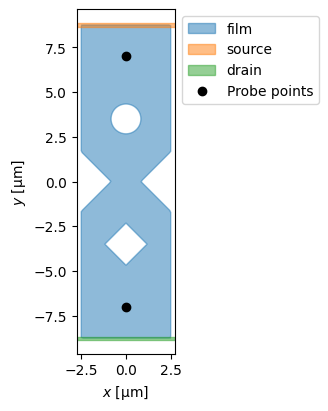

In [10]:
fig, ax = device.draw()

In [11]:
device.make_mesh(max_edge_length=xi / 2, smooth=100)

Constructing Voronoi polygons: 100%|█████| 4622/4622 [00:00<00:00, 21281.58it/s]


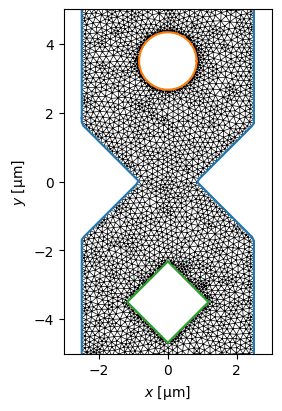

In [12]:
fig, ax = device.plot(mesh=True, legend=False)
_ = ax.set_ylim(-5, 5)

In [13]:
device.mesh_stats()

num_sites,4622
num_elements,8650
min_edge_length,3.760e-02
max_edge_length,2.671e-01
mean_edge_length,1.413e-01
min_area,8.094e-04
max_area,3.771e-02
mean_area,1.666e-02
coherence_length,5.000e-01
length_units,um


In [14]:
options = tdgl.SolverOptions(
    # Allow some time to equilibrate before saving data.
    skip_time=100,
    solve_time=150,
    output_file=os.path.join(tempdir.name, "weak-link-zero-field.h5"),
    field_units = "mT",
    current_units="uA",
    save_every=100,
)
# If you do not provide an applied_vector_potential, tdgl defaults to zero applied field.
zero_field_solution = tdgl.solve(
    device,
    options,
    # terminal_currents must satisfy current conservation, i.e.,
    # sum(terminal_currents.values()) == 0.
    terminal_currents=dict(source=12, drain=-12),
)

Simulating: 100%|███████████████████████████| 150/150 [00:29<00:00,  5.11tau/s ]


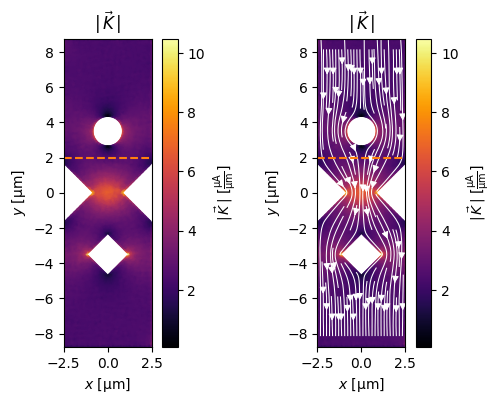

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

_ = zero_field_solution.plot_currents(ax=axes[0], streamplot=False)
_ = zero_field_solution.plot_currents(ax=axes[1])
# Define the coordinates at which to evaluate the sheet current density
x = np.linspace(-total_width / 2, total_width / 2, 401)
y = 2 * np.ones_like(x)
cross_section = np.array([x, y]).T
for ax in axes:
    _ = ax.plot(x, y, "C1--")

In [16]:
current = zero_field_solution.current_through_path(cross_section)
print(f"Measured current: {current:.3f~P}")

Measured current: 11.980 µA


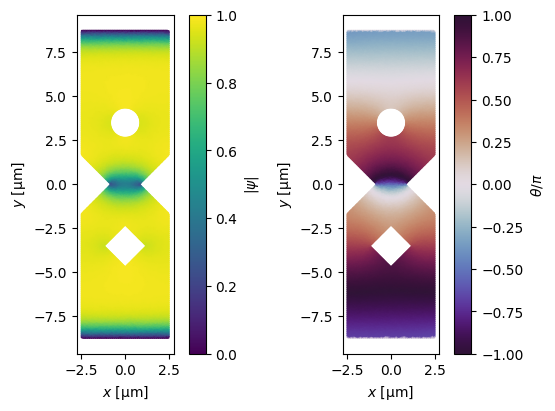

In [17]:
# Plot a snapshot of the order parameter in the middle of a phase slip
t0 = 112
zero_field_solution.solve_step = zero_field_solution.closest_solve_step(t0)
fig, axes = zero_field_solution.plot_order_parameter(figsize=(5.5, 4))

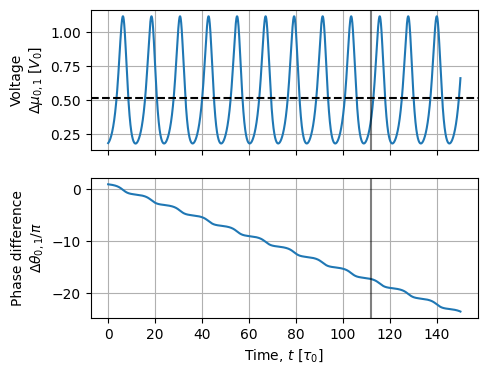

In [19]:
fig, axes = zero_field_solution.dynamics.plot()
for ax in axes:
    ax.axvline(t0, color="k", alpha=0.5)

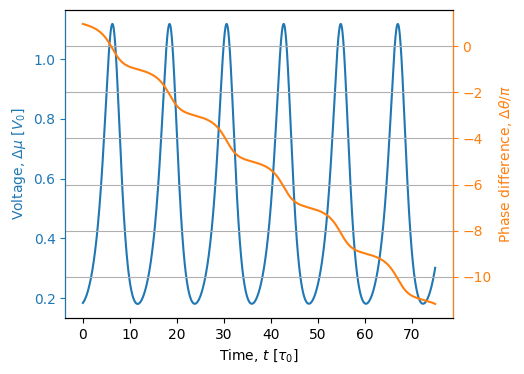

In [20]:
dynamics = zero_field_solution.dynamics
indices = dynamics.time_slice(tmax=75)

fig, ax = plt.subplots()
# Plot the voltage on the left y axis
ax.plot(dynamics.time[indices], dynamics.voltage()[indices], "C0-")
ax.tick_params(axis="y", color="C0", labelcolor="C0")
ax.set_ylabel("Voltage, $\\Delta\\mu$ [$V_0$]", color="C0")
ax.set_xlabel("Time, $t$ [$\\tau_0$]")

# Plot the phase difference on the right y axis
bx = ax.twinx()
unwrapped_phase = np.unwrap(dynamics.phase_difference()[indices])
bx.plot(dynamics.time[indices], unwrapped_phase / np.pi, "C1")
bx.grid(axis="both")
bx.spines["right"].set_color("C1")
bx.spines["left"].set_color("C0")
bx.tick_params(axis="y", color="C1", labelcolor="C1")
_ = bx.set_ylabel("Phase difference, $\\Delta\\theta/\\pi$", color="C1")

In [21]:
if MAKE_ANIMATIONS:
    zero_field_video = make_video_from_solution(
        zero_field_solution,
        quantities=["order_parameter", "phase", "scalar_potential"],
        figsize=(6.5, 4),
    )
    display(zero_field_video)